In [1]:
if("quantmod" %in% rownames(installed.packages()) == FALSE) 
    {install.packages("quantmod")}
if("tidyquant" %in% rownames(installed.packages()) == FALSE) 
    {install.packages("tidyquant")}

In [2]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(car)
library(janitor)
library(scales)

library(tidyquant)
library(caret)

library(rvest)
library(dplyr)
library(readr)
library(tidyr)
library(stringr)

library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Loading required package: lubridate


Attaching pa

In [3]:
options("getSymbols.warning4.0"=FALSE)
options("getSymbols.yahoo.warning"=FALSE)

# Project Proposal


**Yiou Long, Nikko Dumrique, Andres Zepeda, Medha Singh**

`Monday November 26th 2021`

### Introduction

The stock market is a stochastic process; the prices of each stock depends on multiple random variables (Kenton, 2021). Some of these factors include supply-demand outlooks, companies and supply chain performance as well as volume of shares being traded (Team, 2021). In this project, we will explore correlation between the stock price change of the suppliers of semiconductor manufacturers and the effects of that on the stock prices of the semiconductor manufacturers companies such as Intel, Apple, and AMD. In simple words, we want to see if the stock price of semiconductor manufacturing companies fluctuate along with the revenue change of their suppliers, considering a delayed effect.

For the stock prices, we will use the dataset from Yahoo Finance; and for the revenue of suppliers, we will use dataset from csimarket. 

Our response variable is the closing stock price of a semiconductor manufacturer (Intel)(Wheatley, 2021). Explanatory variables will include Intel and competitors’ open, high, low, close and volume of the previous day’s, as well as Intel’s suppliers stock performance (in %) for 1 day, 5 day, 1 month, 3 month, and 1 year. We include such delayed information because it can take a while for supplier performance to impact manufacturers. 


### Exploratory Data Analysis (EDA)

To begin our exploratory analysis we will visualize the stocks we believe are related to the Intel. We have included stocks that are within the supply chain of Intel. These stocks we included are related as either a supplier, consumer, or competitor to Intel: 
> _Advanced Micro Devices_ __AMD__ (_Competitor_)

> _Siltronic AG_           __WAF.DE__ (_Supplier_)

> _3M Company_             __MMM__ (_Supplier_)

>_Apple Inc_               __AAPL__ (_Consumer_)

> _Dell Technologies Inc._ __DELL__ (_Consumer_)

The data we pull comes from Yahoo Finance via a REST API query using the library `tidyquant` and we decided to pull data from 09-01-2014 to 03-01-2019.


Features of queried data:

- `date`: date for which the data is collected
- `open`: is the open price which is the first price a stock trades at during the day.
- `high`: the highest price at which the stocks were traded for the day
- `low`: and lowest price at which the stocks were traded for the day
- `close`: is the open price which is the first price a stock trades at during the day.
- `volume`: measures the number of a stock's shares that are traded on a stock exchange in a day or a period of time


In [4]:
#pulling data from Yahoo finance API
intel_index <- tq_get(c('INTC','WAF.DE','AMD','AAPL','DELL', "MMM"),
               from = "2014-09-01",
               to = "2019-03-01",
               get = "stock.price")

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip



In [5]:
head(intel_index)
tail(intel_index)
nrow(intel_index)

symbol,date,open,high,low,close,volume,adjusted
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
INTC,2014-09-02,34.76,34.91,34.43,34.57,32094800,28.41110
INTC,2014-09-03,34.82,34.88,34.45,34.57,26668800,28.41110
INTC,2014-09-04,34.53,35.09,34.52,34.91,27632400,28.69052
INTC,2014-09-05,34.92,35.12,34.83,35.00,20841900,28.76448
INTC,2014-09-08,34.96,35.56,34.88,35.33,24859600,29.03570
INTC,2014-09-09,35.29,35.29,34.85,34.91,22333100,28.69052


symbol,date,open,high,low,close,volume,adjusted
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MMM,2019-02-21,208.16,209.11,207.25,207.77,1737600,189.1189
MMM,2019-02-22,207.77,209.66,207.15,209.35,1534200,190.5570
MMM,2019-02-25,210.47,211.35,210.34,210.58,2183500,191.6766
MMM,2019-02-26,210.58,211.59,209.37,209.38,1671300,190.5843
MMM,2019-02-27,209.60,209.69,208.16,209.03,1540600,190.2658
MMM,2019-02-28,209.05,209.05,206.96,207.39,2121700,188.7730


[1] 6109

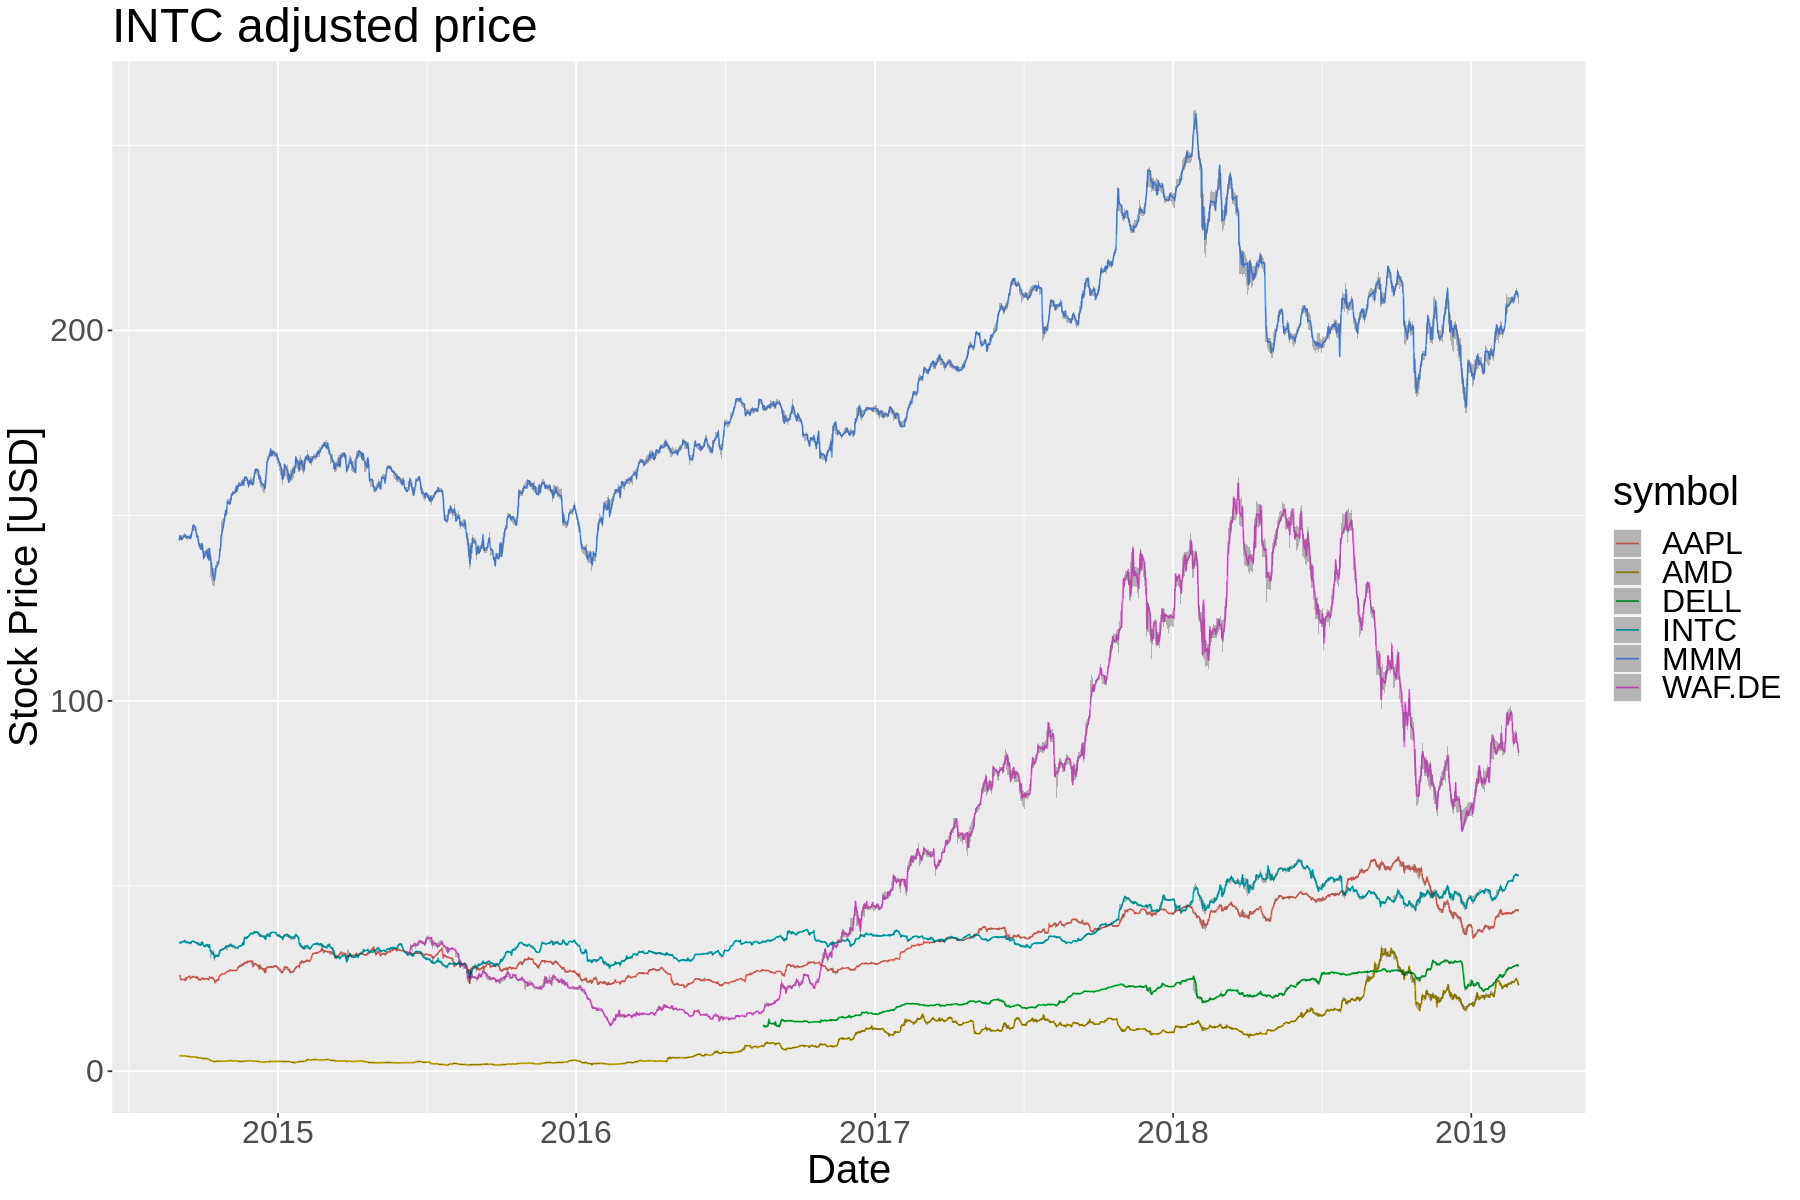

In [6]:
options(repr.plot.width = 15, repr.plot.height = 10)

#plotting the open price of each stock. 
#The grey region around the lines indicate the high and low bounds of that day
intel_plt = intel_index |> 
    group_by(symbol) |>
    mutate(symbol = factor(symbol)) |>
    ggplot() +
    geom_line(aes(x = date, 
                  y = open,
                  color = symbol)
             ) + 
    geom_ribbon(aes(x = date,
                    y = open,
                    ymin=low,
                    ymax=high,
                    color = symbol),fill = "black",
                alpha = 0.255, linetype=0
               ) +
    ggtitle('INTC adjusted price') + 
    xlab('Date') +
    ylab('Stock Price [USD]') +
    theme(text = element_text(size = 24)) +
    scale_fill_manual("",values="black")
    
intel_plt

The dark gray ribbon depicting the high and low of that days stock price is tightly bounding the opening price. This is expected as `open, high, low, close, and adjusted` essentially depict the same data (with some noise factor). To reduce complexity of our model, we will utilize the adjusted price to represent the value and also include volume.

Warning message:
“Removed 6078 row(s) containing missing values (geom_path).”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


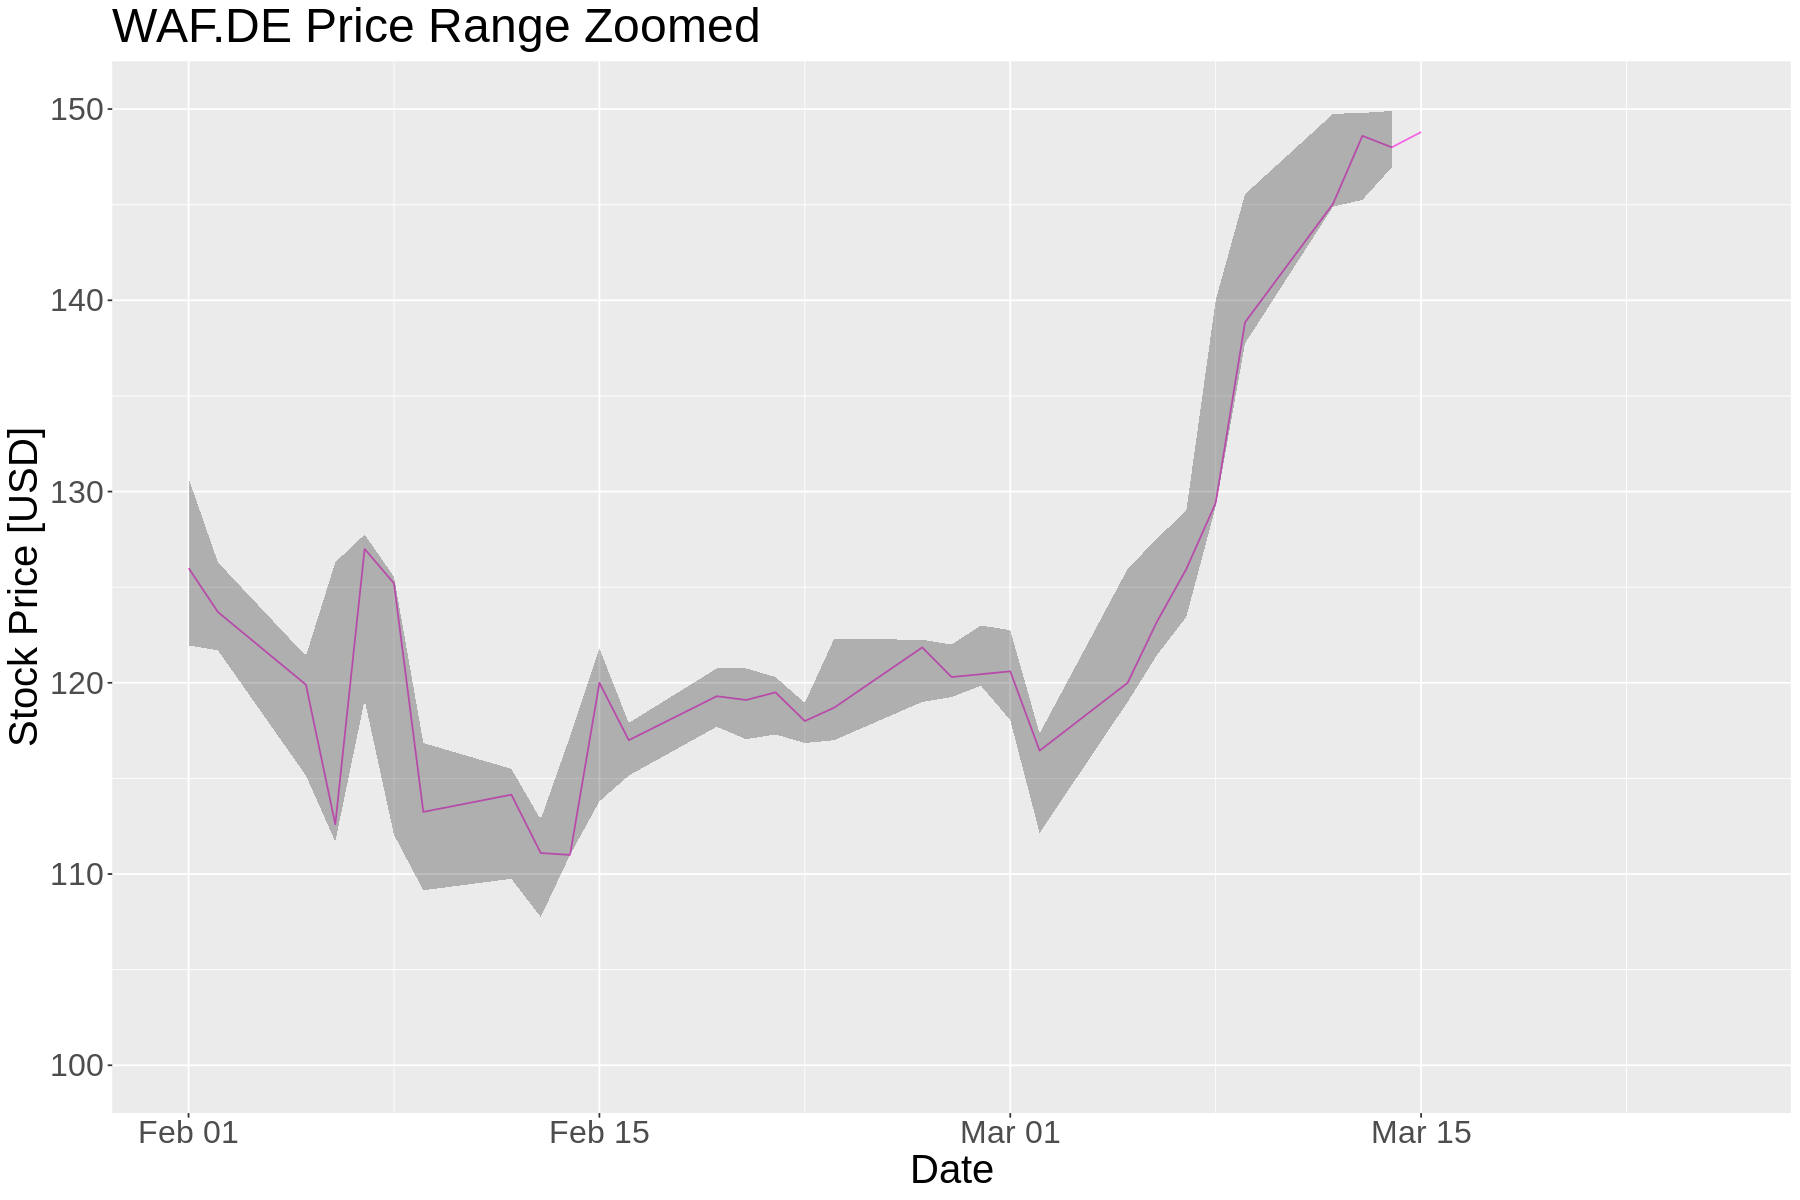

In [7]:
#Zooming into WAF.DE to depict the gray ribbon
intel_plt_zoom = intel_plt +
                xlim(as.Date('2018-02-01'),as.Date('2018-03-25')) + 
                ylim(100,150) +
                ggtitle("WAF.DE Price Range Zoomed") +
                theme(legend.position = "none")
intel_plt_zoom

In [8]:
#Selecting our wanted features from the data
intel_index = intel_index |> 
    select(symbol, date, adjusted, volume) |>
    pivot_wider(names_from = 'symbol', 
                values_from = c('volume', 'adjusted')) |> 
    mutate(month = month(date))

In [9]:
#standardizing data and removing NA observations
intel_index[,2:13] = intel_index[,2:13] |>
    mutate_all(~(scale(.) %>% as.vector)) 

In [10]:
#filter out observations with NA
intel_index = intel_index[complete.cases(intel_index),]
head(intel_index)
nrow(intel_index)

date,volume_INTC,volume_WAF.DE,volume_AMD,volume_AAPL,volume_DELL,volume_MMM,adjusted_INTC,adjusted_WAF.DE,adjusted_AMD,adjusted_AAPL,adjusted_DELL,adjusted_MMM,month
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-08-17,-0.7209934,-0.92066332,-0.7865773,-0.6958947,-0.6859714,-0.9124829,-0.4134617,-1.153196,-0.3671756,-0.8173024,-1.961177,-0.1439941,8
2016-08-18,-0.8985088,0.04563529,-0.3923705,-0.8670596,-0.5301094,-1.1801923,-0.4192080,-1.109062,-0.3160777,-0.8210092,-1.976696,-0.1650684,8
2016-08-19,-0.8708893,-0.46422334,0.6364369,-0.6952803,-0.2207986,-0.9651146,-0.3881756,-1.101506,-0.2337533,-0.8135940,-1.930141,-0.1519352,8
2016-08-22,-0.9935481,-0.70116378,-0.1433024,-0.6723267,-0.4802469,-0.9343468,-0.3743855,-1.119685,-0.2394308,-0.8361039,-1.920830,-0.1684274,8
2016-08-23,-0.7131496,-0.76925633,-0.4678201,-0.9039703,-0.5597373,-1.0734449,-0.3697875,-1.112785,-0.2266563,-0.8271002,-1.837031,-0.1470494,8
2016-08-24,-0.8770464,-0.68337785,-0.5742411,-0.7812360,-0.4510646,-1.1315178,-0.3985206,-1.111471,-0.2607216,-0.8488155,-1.799787,-0.1580436,8


[1] 627

In [11]:
#Correlation between response variables
index_correlation = intel_index[,2:14] |> 
    ggpairs(progress = FALSE) +
    theme (
        text = element_text(size = 15),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold")
    )

[1] "This plot shows the distribution of each features and their correlation with each other."


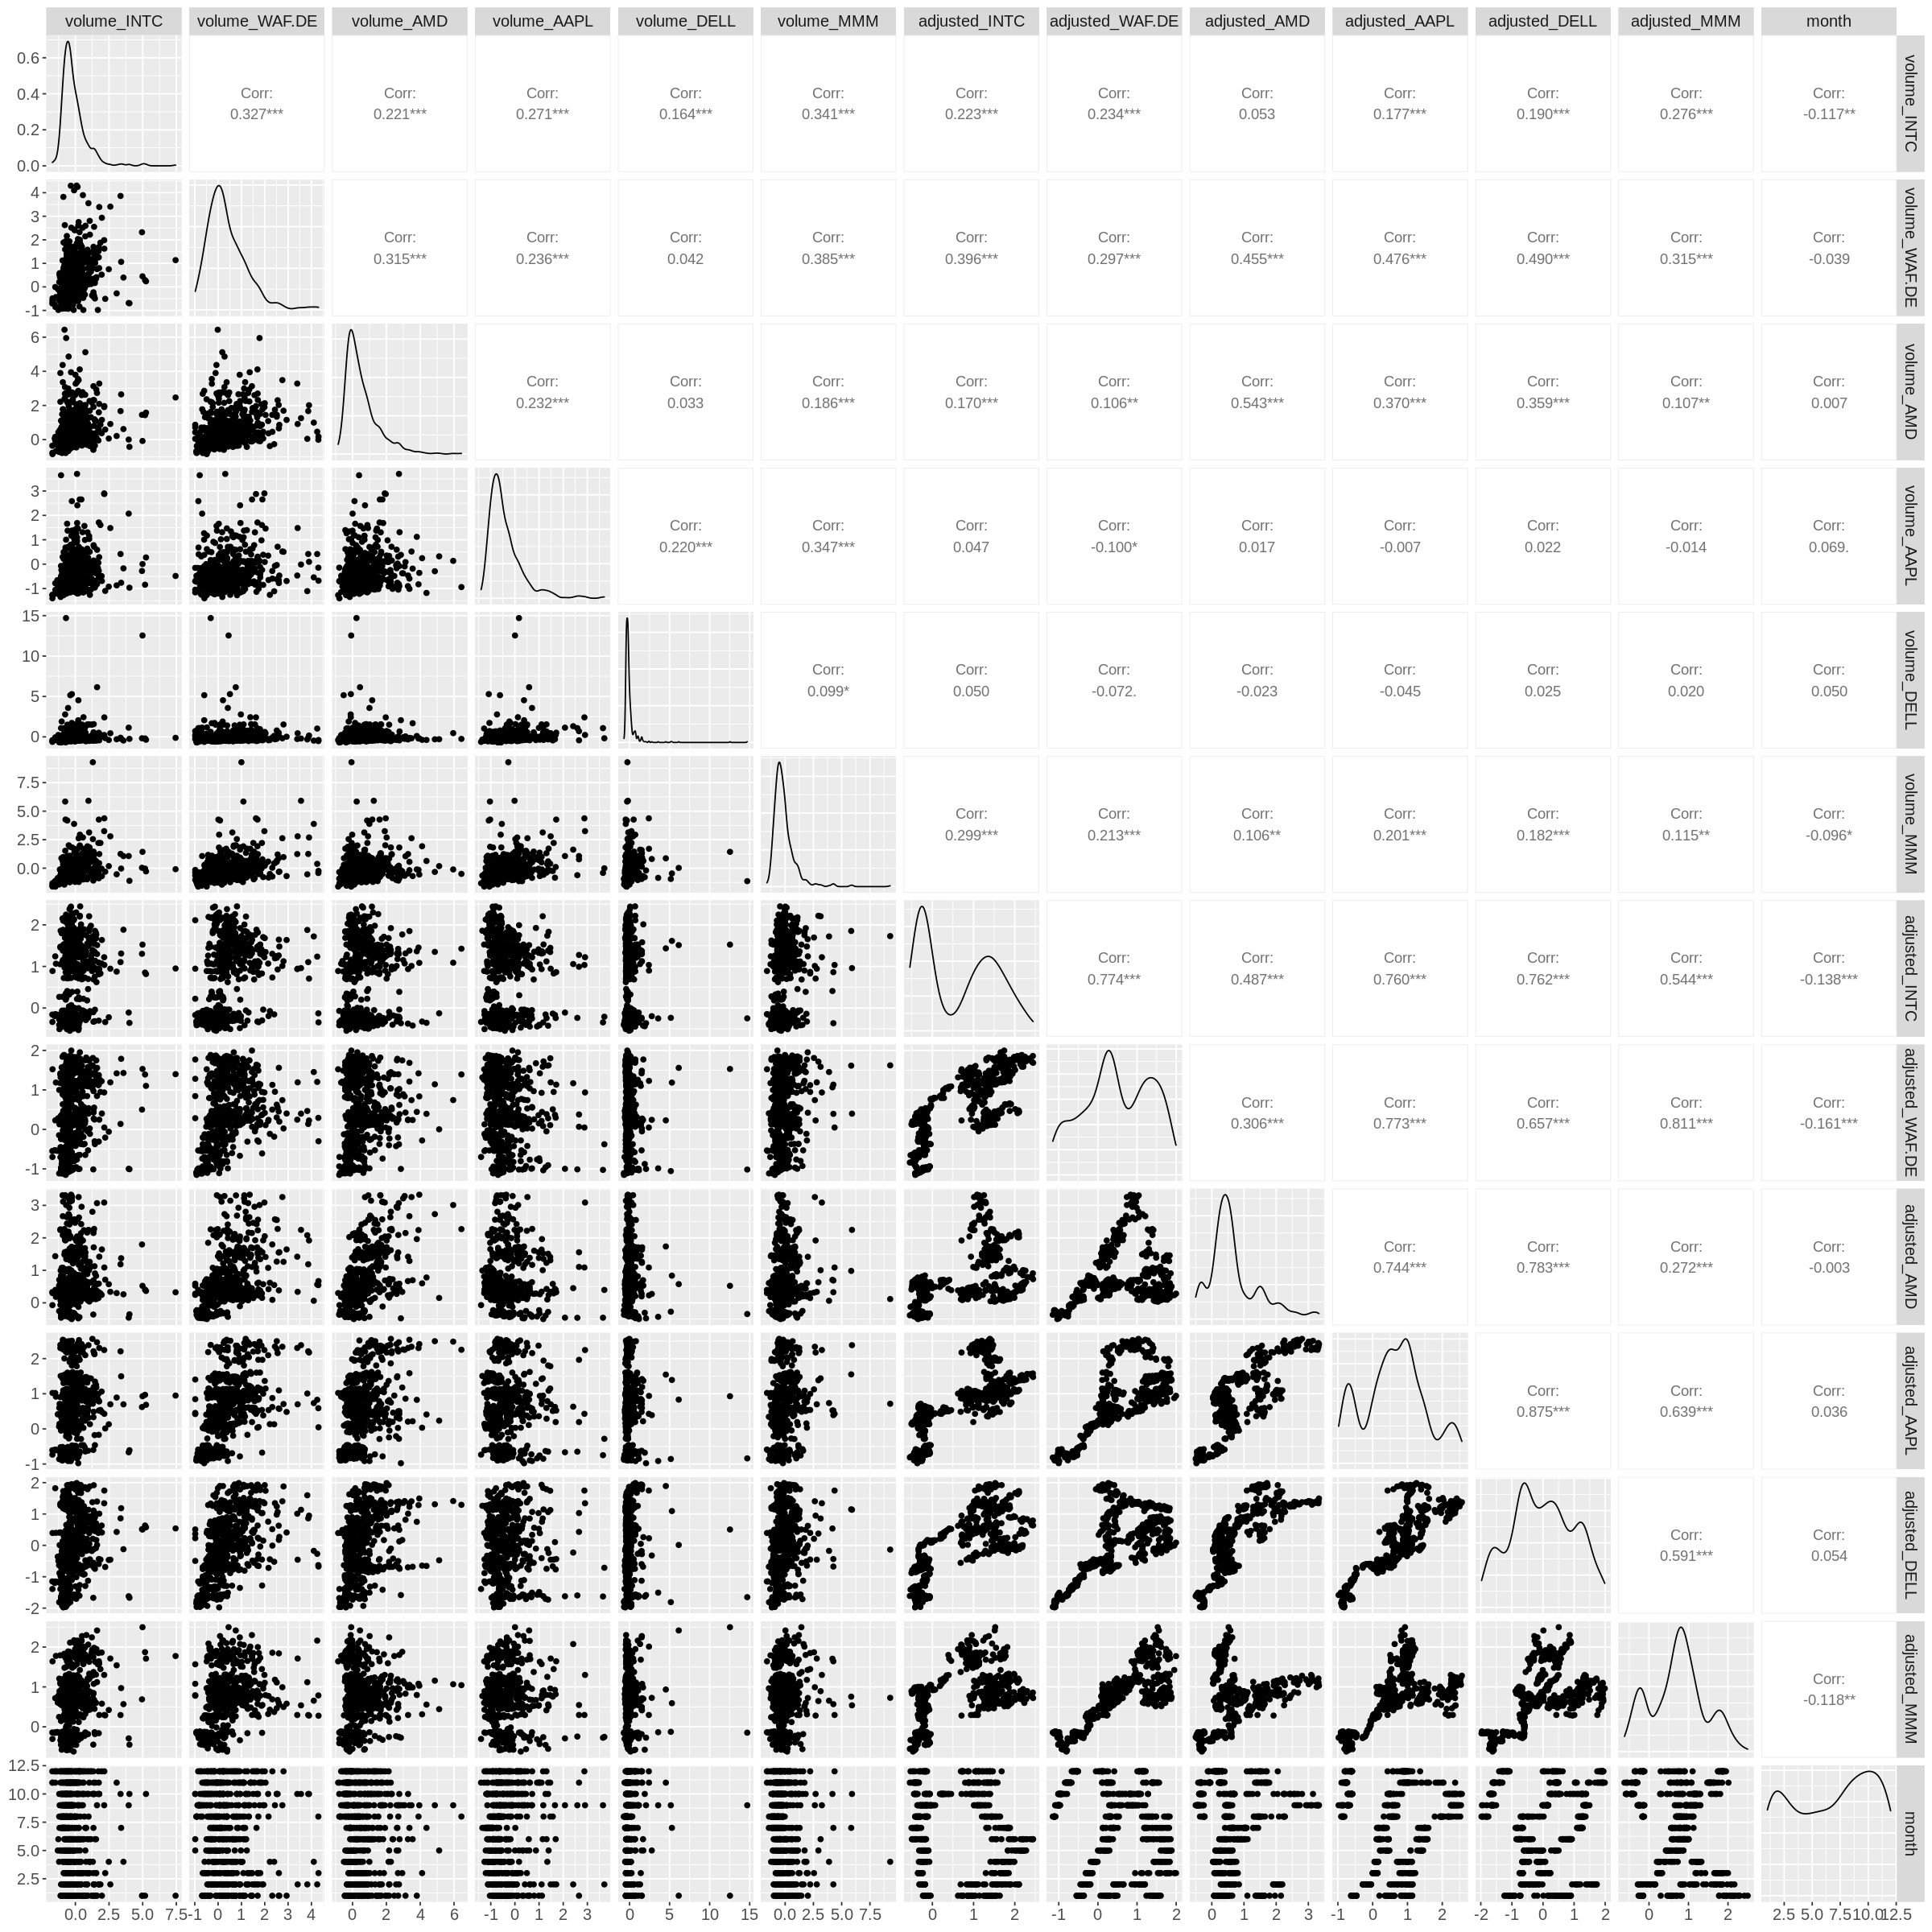

In [12]:
#plotting the matrix
options(repr.plot.width = 20, repr.plot.height = 20)
index_correlation

print("This plot shows the distribution of each features and their correlation with each other.")

 We will display a heat-map of the correlation.

In [13]:
#initialize correlation matrix
corr_matrix_intel_index = intel_index[,2:14] |> 
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")
head(corr_matrix_intel_index)

var1,var2,corr
<chr>,<chr>,<dbl>
volume_INTC,volume_INTC,1.0000000
volume_INTC,volume_WAF.DE,0.3267748
volume_INTC,volume_AMD,0.2208188
volume_INTC,volume_AAPL,0.2705980
volume_INTC,volume_DELL,0.1637125
volume_INTC,volume_MMM,0.3408917


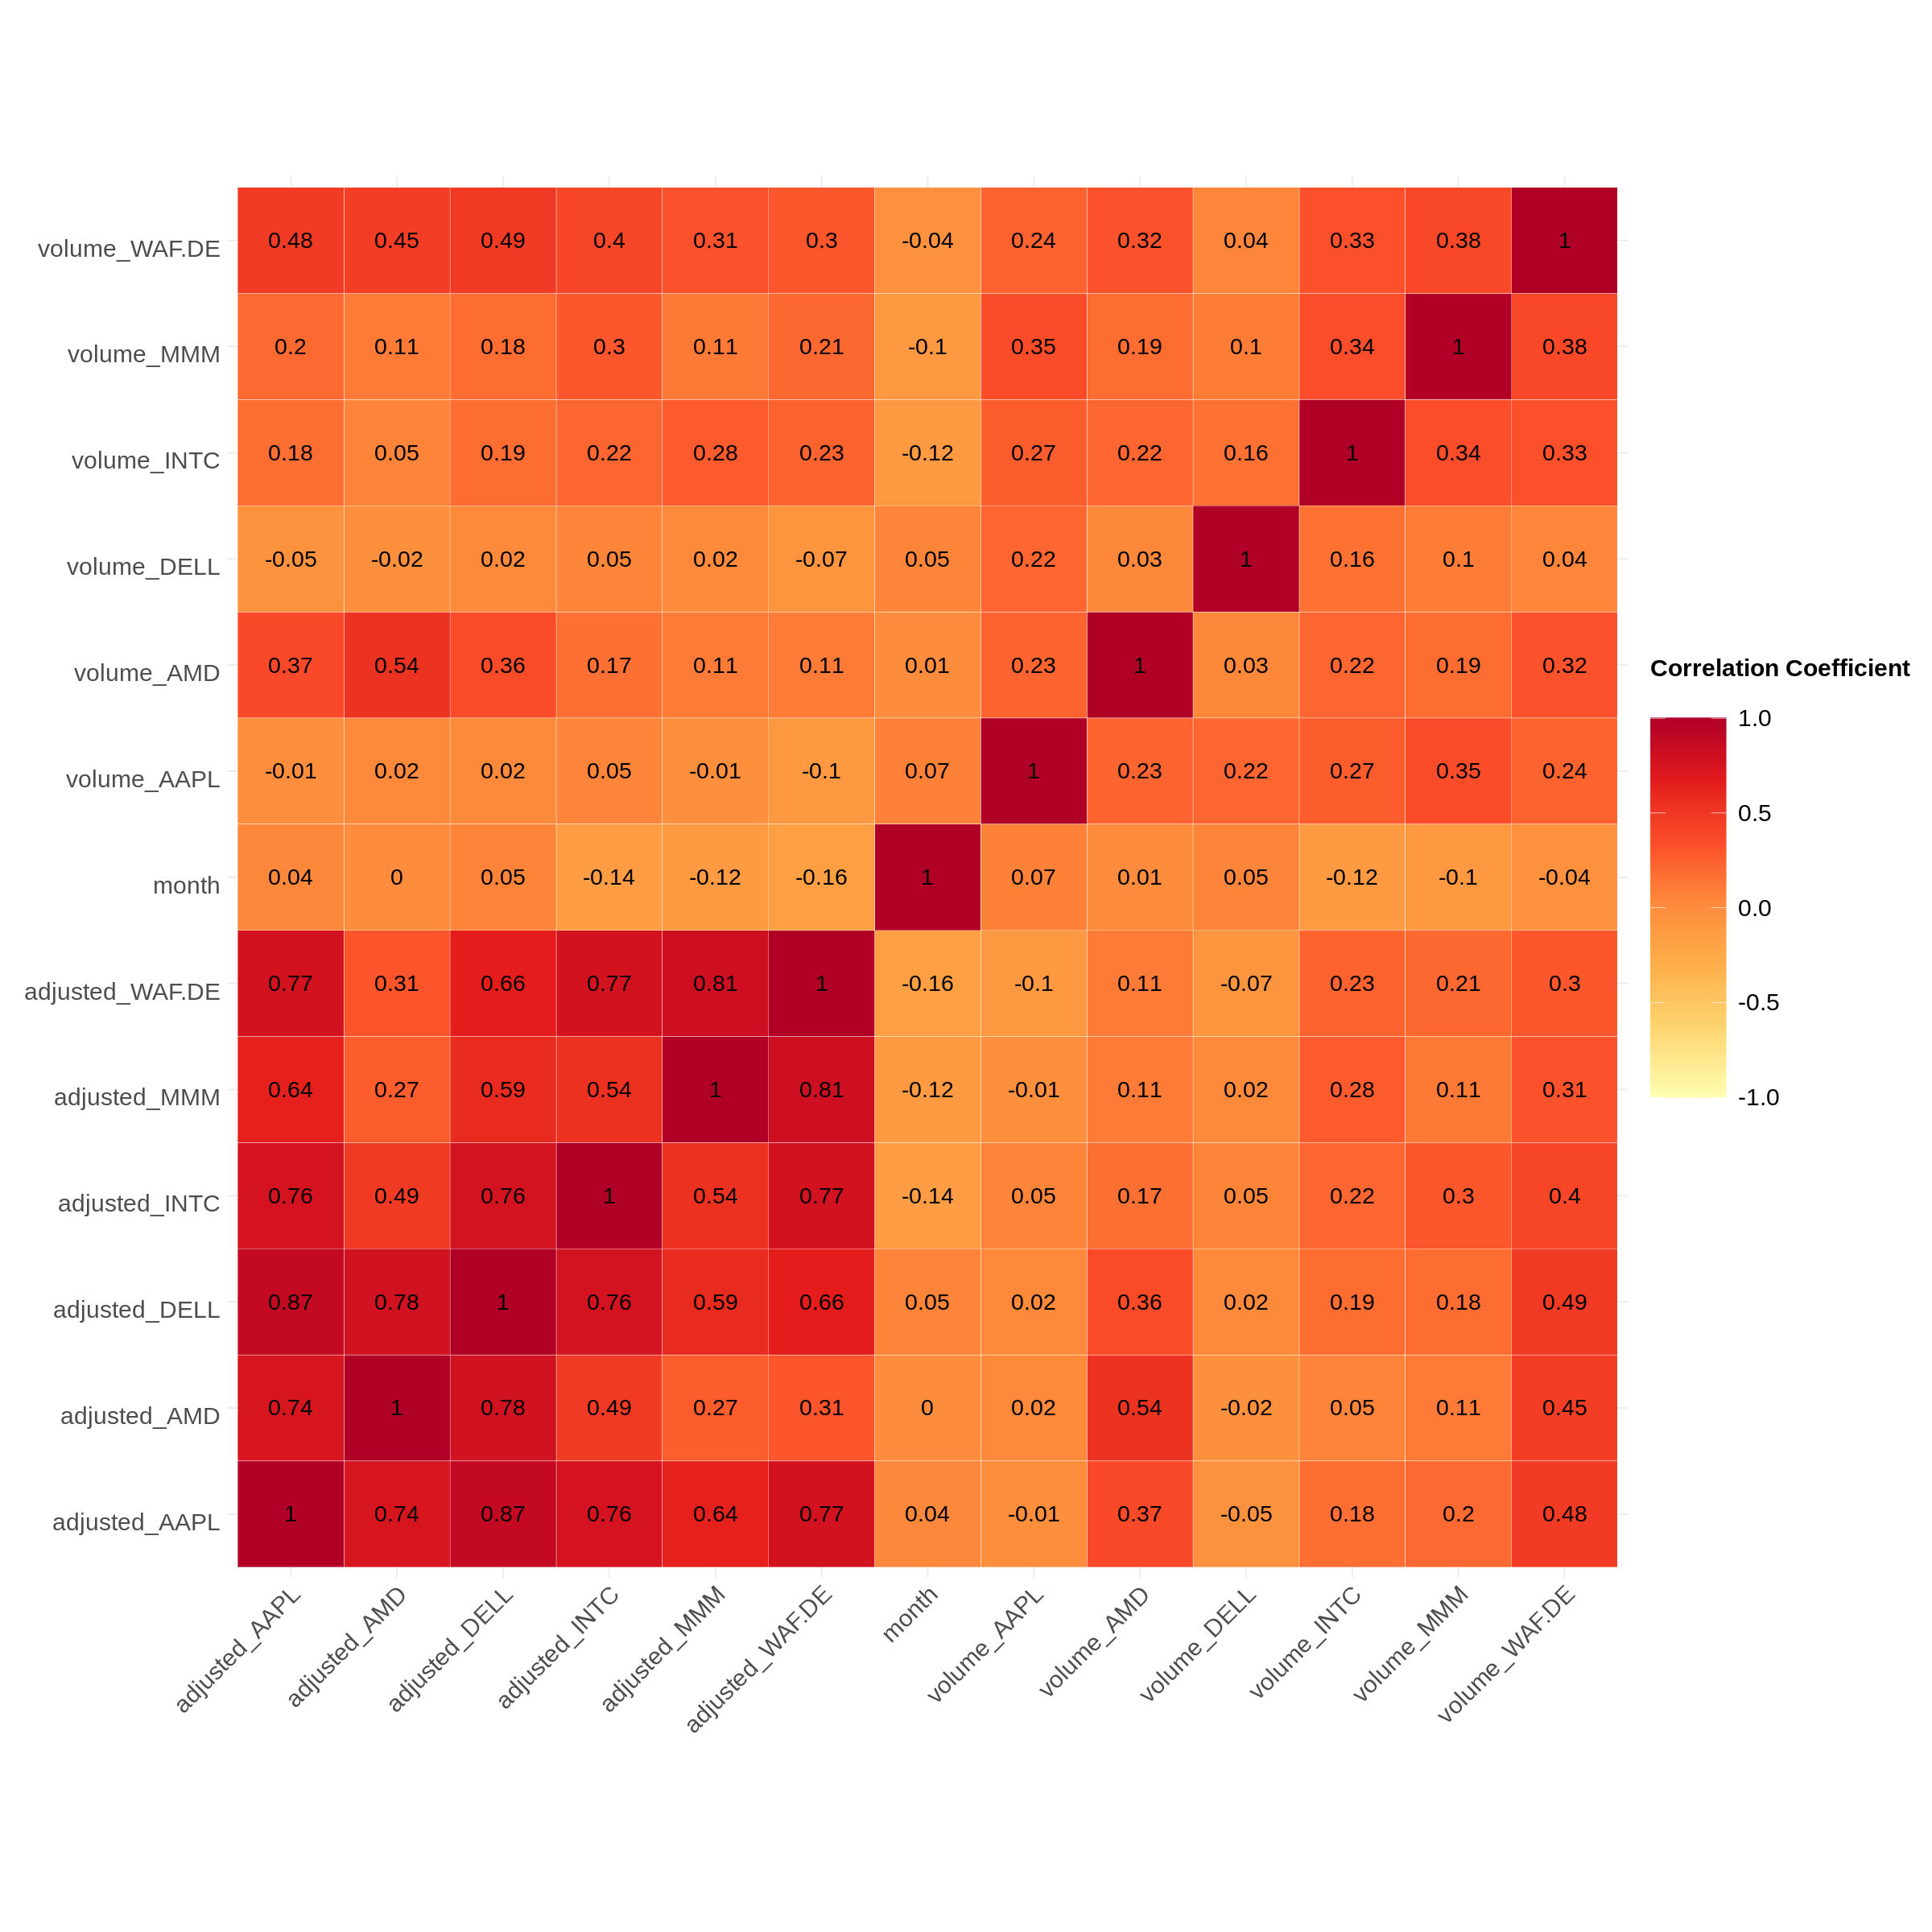

In [14]:
#correlation heatmap
plt_index_corr_matrix <- corr_matrix_intel_index %>%
  ggplot(aes(var1, var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette = "YlOrRd",
    direction = 1, limits = c(-1, 1)
  ) +
  labs(x = "", y = "") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 18, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 18, hjust = 1
    ),
    legend.title = element_text(size = 18, face = "bold"),
    legend.text = element_text(size = 18),
    legend.key.size = unit(2, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(var2, var1, label = round(corr, 2)), color = "black", size = 6)
plt_index_corr_matrix

From `adjusted_INTC` on vertical axis, the adjusted stock prices of other companies show a promising correlation. Likewise volumes of AMD, INTC, MMM, and WAF.DE are also potential indicators of the stock price for Intel.

As we see above, there are several variables with high multicollinarity. This data quantifies essentially the same thing over different periods of time. We should account for this with Ridge Linear model. Therefore, we will gather more data that assess the performance of supply chain.

### Methods: Plan

In what ways is this report trustworthy?
> There are multiple sources for the problem statement of suppliers affecting manufacturers, we are exploring the relationship in the relative stock prices, which is mostly new (Wheatley, 2021). The data is trustworthy as the sources are trustworthy, Yahoo Finance and CSIMarket and known websites.

What methods do you plan on using?
> MLR with partial interactions. Much of our data is split into their own "groups" with their own information and so there will be interactions within those groups, but not outside.

What do you expect to achieve?
> An insight towards the relation between supplier stock performance to stock performance in the tech industry, particularly computer part manufacturing. A failing supplier can have effects on how much a company can produce, but what can be their effects on the stocks of those companies (Segal, 2021).

What impact could your results have?
> Stock prediction is a famously difficult problem and this model can very useful in developing insight towards future investment strategies that produce reliable performance. A successful predictive model can help inform the volatility associated to certain stocks. 


In [15]:
#showing correlation
corr_matrix_intel_index <- intel_index %>%
  ungroup() %>%
  select(
      adjusted_INTC, volume_INTC,
      adjusted_AAPL, volume_AAPL,
      adjusted_AMD, volume_AMD,
      adjusted_DELL, volume_DELL,
      adjusted_MMM, volume_MMM,
      adjusted_WAF.DE, volume_WAF.DE,
      month
  ) %>%
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")
head(corr_matrix_intel_index)

var1,var2,corr
<chr>,<chr>,<dbl>
adjusted_INTC,adjusted_INTC,1.00000000
adjusted_INTC,volume_INTC,0.22270744
adjusted_INTC,adjusted_AAPL,0.76015237
adjusted_INTC,volume_AAPL,0.04650225
adjusted_INTC,adjusted_AMD,0.48733099
adjusted_INTC,volume_AMD,0.16958487


The full data of what we will be using from CSI looks as follows:

In [16]:
# Reading that new information
pop <- read_html("https://csimarket.com/stocks/competitionNO2.php?supply&code=INTC")

In [17]:
#First, getting the info
company_name <- paste(".block a",sep=",")
company_name_node <- html_nodes(pop, company_name)
company_name_text <- html_text(company_name_node)%>% data.frame()

#wrangling and scraping data
ticker <- paste(".ff00",".dae",sep=",")
ticker_node <- html_nodes(pop, ticker)
ticker_text <- html_text(ticker_node)%>% data.frame()

one_day<- paste(".ff00+ .ac" , ".dae+ .f11", sep=",")
one_day_node <- html_nodes(pop, one_day)
one_day_text <- html_text(one_day_node)%>% parse_number()%>%data.frame()

five_days <- paste(".ddd:nth-child(4)" , ".subcomp11:nth-child(4)", sep= ",")
five_days_node <- html_nodes(pop, five_days)
five_days_text <- html_text(five_days_node)%>% parse_number()%>%data.frame()

thirty_days <- paste(".subcomp11:nth-child(5)" , ".svjetlirub:nth-child(5)", sep= ",")
thirty_days_node <- html_nodes(pop, thirty_days)
thirty_days_text <- html_text(thirty_days_node)%>% parse_number()%>%data.frame()

ninety_days <- paste(".subcomp11:nth-child(6)" , ".ddd~ .ddd", sep= ",")
ninety_days_node <- html_nodes(pop, ninety_days)
ninety_days_text <- html_text(ninety_days_node)%>% parse_number()%>%data.frame()

year <- paste(".subcomp11:nth-child(7)", ".svjetlirub:nth-child(7)",sep=",")
year_nodes <- html_nodes(pop, year)
year_text <- html_text(year_nodes)%>% parse_number()%>%data.frame()


Warning message:
“44 parsing failures.
row col expected actual
  2  -- a number      -
  3  -- a number      -
 15  -- a number      -
 16  -- a number      -
 17  -- a number      -
... ... ........ ......
See problems(...) for more details.
”
Warning message:
“44 parsing failures.
row col expected actual
  2  -- a number      -
  3  -- a number      -
 15  -- a number      -
 16  -- a number      -
 17  -- a number      -
... ... ........ ......
See problems(...) for more details.
”
Warning message:
“44 parsing failures.
row col expected actual
  2  -- a number      -
  3  -- a number      -
 15  -- a number      -
 16  -- a number      -
 17  -- a number      -
... ... ........ ......
See problems(...) for more details.
”
Warning message:
“44 parsing failures.
row col expected actual
  2  -- a number      -
  3  -- a number      -
 15  -- a number      -
 16  -- a number      -
 17  -- a number      -
... ... ........ ......
See problems(...) for more details.
”
Warning message:
“44

In [18]:
#Merging the dataFrames
suppliers_data <- cbind(company_name_text, ticker_text, one_day_text, five_days_text, thirty_days_text, ninety_days_text, year_text)
colnames(suppliers_data, do.NULL = FALSE)
colnames(suppliers_data) <- c("company_name","ticker", "one_day", "five_days", "thirty_days","ninety_days", "ytd")

#Dropping Null values
suppliers_data <- drop_na(suppliers_data)

head(suppliers_data)

[1] "." "." "." "." "." "." "."

,company_name,ticker,one_day,five_days,thirty_days,ninety_days,ytd
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Intel Corporation,INTC,-1.20,-0.72,-0.30,-8.42,-0.54
2,3m Company,MMM,-3.00,-3.76,-4.81,-12.86,-0.54
3,Applied Materials Inc,AMAT,-1.63,-0.17,6.62,9.33,71.23
4,Dover Corp,DOV,-4.15,-6.57,-3.00,-6.33,33.50
5,Freeport mcmoran Inc,FCX,-1.97,-3.67,-2.87,1.61,37.18
6,International Business Machines Corporation,IBM,-0.95,0.56,-7.05,-15.54,-5.29


In [19]:
companies <- c(ticker_text$., c('INTC','WAF.DE','AMD','AAPL','DELL', "MMM"))
companies <- companies[!duplicated(companies)]
companies

[1] "INTC"   "REE"    "NIOBF"  "MMM"    "AMAT"   "DOV"    "FCX"    "IBM"   
 [9] "KLAC"   "MSFT"   "NEM"    "TER"    "A"      "LRCX"   "ATOM"   "ASTC"  
[17] "ATRO"   "SIF"    "ESE"    "ANSS"   "AZPN"   "CDNS"   "NATI"   "PAYC"  
[25] "PCTY"   "ALTR"   "MODN"   "AMKR"   "ASX"    "CEVA"   "FORM"   "KLIC"  
[33] "PKE"    "TSEM"   "VIAV"   "TSM"    "ASML"   "AAOI"   "WTM"    "EMKR"  
[41] "NPTN"   "HLIT"   "LWLG"   "NTGR"   "PRKR"   "SEAC"   "IIVI"   "SEE"   
[49] "PX"     "DOW"    "PNR"    "PTC"    "TAIT"   "LXU"    "CCMP"   "SPRS"  
[57] "APD"    "B"      "IPHI"   "MXL"    "AMPG"   "LITE"   "WAF.DE" "AMD"   
[65] "AAPL"   "DELL"

In [20]:
#API call to pull "lagged" data from supply chain and competitor companies
start_date = "2014-09-01"
supplier_index <- tq_get(companies,
               from = "2018-01-01", 
               to = "2019-03-01",
               get = "stock.price") 
supplier_index <- supplier_index %>% mutate(ticker = supplier_index$symbol)
supplier_historical_index <- tq_get(companies,
               from = "2017-01-01", #one year earlier because we need 1 year previous data
               to = "2019-03-01",
               get = "stock.price") 
supplier_historical_index <- supplier_historical_index %>% mutate(ticker = supplier_historical_index$symbol)
head(supplier_index)

Warning message:
“x = 'REE', get = 'stock.prices': Error in getSymbols.yahoo(Symbols = "REE", env = <environment>, verbose = FALSE, : Unable to import “REE”.
argument "conn" is missing, with no default
 Removing REE.”
Warning message:
“x = 'PX', get = 'stock.prices': Error in getSymbols.yahoo(Symbols = "PX", env = <environment>, verbose = FALSE, : Unable to import “PX”.
argument "conn" is missing, with no default
 Removing PX.”
Warning message:
“x = 'DOW', get = 'stock.prices': Error in getSymbols.yahoo(Symbols = "DOW", env = <environment>, verbose = FALSE, : Unable to import “DOW”.
argument "conn" is missing, with no default
 Removing DOW.”
Warning message:
“x = 'IPHI', get = 'stock.prices': Error in getSymbols.yahoo(Symbols = "IPHI", env = <environment>, verbose = FALSE, : Unable to import “IPHI”.
argument "conn" is missing, with no default
 Removing IPHI.”
Warning message:
“x = 'AMPG', get = 'stock.prices': Error in getSymbols.yahoo(Symbols = "AMPG", env = <environment>, verbose = F

symbol,date,open,high,low,close,volume,adjusted,ticker
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
INTC,2018-01-02,46.38,46.90,46.21,46.85,23370800,42.40626,INTC
INTC,2018-01-03,45.47,46.21,43.65,45.26,116479000,40.96707,INTC
INTC,2018-01-04,43.52,44.65,42.69,44.43,89209100,40.21580,INTC
INTC,2018-01-05,44.43,45.15,43.90,44.74,41824000,40.49641,INTC
INTC,2018-01-08,44.27,44.84,43.96,44.74,33733800,40.49641,INTC
INTC,2018-01-09,44.70,44.84,43.49,43.62,44282300,39.48263,INTC


Let me explain what is going on here (the next cell): 1) I am morphing the table above to have a value of their percent change of stock in 1 day 2) Then I am adding the rows to also have the data of 1 month prev, (soon to add the 5day, 3 month, etc) 3) After that it will be pull in the open from that date (with supplier_historical) and calcululate the percentage change from then 4) NOTE: RUNS VERY SLOW 5) Then it will be the like the pivot_wider in the 7th cell of this sheet, to expand everything based on date 6) Then merge with that of the two tables using the dates 7) Although for just the proposal, the table above is fine, as we just need to show we have the data and it has what we are looking for

In [21]:
#Wrangling and tidying newly API queried data.
ticker_df = data.frame(supplier_index$ticker[1])
today_df = data.frame(supplier_index$date[1])

one_day_df = data.frame(one_day = seq(from = as.Date(supplier_index$date[1]), length = 2, by = "-1 day")[2])
five_day_df = data.frame(five_day = seq(from = as.Date(supplier_index$date[1]), length = 2, by = "-5 days")[2])
one_month_df = data.frame(one_month = seq(from = as.Date(supplier_index$date[1]), length = 2, by = "-1 month")[2])
three_month_df = data.frame(three_month = seq(from = as.Date(supplier_index$date[1]), length = 2, by = "-3 months")[2])
one_year_df = data.frame(one_year = seq(from = as.Date(supplier_index$date[1]), length = 2, by = "-1 year")[2])

supplier_index_tidy_ <- supplier_index %>%
        mutate(today_oc = open / close) %>%
        select(ticker, date, volume, open, close, today_oc)

for (i in 2:length(supplier_index_tidy_$date)) {
    ticker_df[nrow(ticker_df) + 1, ] <- supplier_index$ticker[i]
    today_df[nrow(today_df) + 1, ] <- supplier_index$date[i]
    one_day_df[nrow(one_day_df) + 1, ] <- seq(from = as.Date(supplier_index$date[i]), length = 2, by = "-1 day")[2]
    five_day_df[nrow(five_day_df) + 1, ] <- seq(from = as.Date(supplier_index$date[i]), length = 2, by = "-5 days")[2]
    one_month_df[nrow(one_month_df) + 1, ] <- seq(from = as.Date(supplier_index$date[i]), length = 2, by = "-1 month")[2]
    three_month_df[nrow(three_month_df) + 1, ] <- seq(from = as.Date(supplier_index$date[i]), length = 2, by = "-3 months")[2]
    one_year_df[nrow(one_year_df) + 1, ] <- seq(from = as.Date(supplier_index$date[i]), length = 2, by = "-1 year")[2]
}
#Today info is for the response variable of intel
dates <- cbind(ticker_df, today_df, one_day_df, five_day_df, one_month_df, three_month_df, one_year_df)
dates <- dates %>% 
    mutate(ticker = supplier_index.ticker.1.) %>%
    mutate(today = supplier_index.date.1.) %>%
    select(ticker, today, today, one_day, five_day, one_month, three_month, one_year)
head(dates)

,ticker,today,one_day,five_day,one_month,three_month,one_year
,<chr>,<date>,<date>,<date>,<date>,<date>,<date>
1,INTC,2018-01-02,2018-01-01,2017-12-28,2017-12-02,2017-10-02,2017-01-02
2,INTC,2018-01-03,2018-01-02,2017-12-29,2017-12-03,2017-10-03,2017-01-03
3,INTC,2018-01-04,2018-01-03,2017-12-30,2017-12-04,2017-10-04,2017-01-04
4,INTC,2018-01-05,2018-01-04,2017-12-31,2017-12-05,2017-10-05,2017-01-05
5,INTC,2018-01-08,2018-01-07,2018-01-03,2017-12-08,2017-10-08,2017-01-08
6,INTC,2018-01-09,2018-01-08,2018-01-04,2017-12-09,2017-10-09,2017-01-09


In [22]:
#Binding wrangled data to original dataset
supplier_index_tidy <- cbind(supplier_index_tidy_, dates) 
supplier_index_tidy <- supplier_index_tidy[, !duplicated(colnames(supplier_index_tidy))]
supplier_index_tidy <- select(supplier_index_tidy, ticker, date, volume, close, open, one_day, five_day, one_month, three_month, one_year)

head(supplier_index_tidy)
tail(supplier_index_tidy)

,ticker,date,volume,close,open,one_day,five_day,one_month,three_month,one_year
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<date>,<date>,<date>,<date>,<date>
1,INTC,2018-01-02,23370800,46.85,46.38,2018-01-01,2017-12-28,2017-12-02,2017-10-02,2017-01-02
2,INTC,2018-01-03,116479000,45.26,45.47,2018-01-02,2017-12-29,2017-12-03,2017-10-03,2017-01-03
3,INTC,2018-01-04,89209100,44.43,43.52,2018-01-03,2017-12-30,2017-12-04,2017-10-04,2017-01-04
4,INTC,2018-01-05,41824000,44.74,44.43,2018-01-04,2017-12-31,2017-12-05,2017-10-05,2017-01-05
5,INTC,2018-01-08,33733800,44.74,44.27,2018-01-07,2018-01-03,2017-12-08,2017-10-08,2017-01-08
6,INTC,2018-01-09,44282300,43.62,44.70,2018-01-08,2018-01-04,2017-12-09,2017-10-09,2017-01-09


,ticker,date,volume,close,open,one_day,five_day,one_month,three_month,one_year
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<date>,<date>,<date>,<date>,<date>
17749,DELL,2019-02-21,3834131,28.15002,28.16016,2019-02-20,2019-02-16,2019-01-21,2018-11-21,2018-02-21
17750,DELL,2019-02-22,3644723,28.47440,28.29701,2019-02-21,2019-02-17,2019-01-22,2018-11-22,2018-02-22
17751,DELL,2019-02-25,4612085,28.70755,28.61632,2019-02-24,2019-02-20,2019-01-25,2018-11-25,2018-02-25
17752,DELL,2019-02-26,4619188,28.75317,28.53523,2019-02-25,2019-02-21,2019-01-26,2018-11-26,2018-02-26
17753,DELL,2019-02-27,3335948,28.50988,28.65687,2019-02-26,2019-02-22,2019-01-27,2018-11-27,2018-02-27
17754,DELL,2019-02-28,8152633,28.29194,28.48454,2019-02-27,2019-02-23,2019-01-28,2018-11-28,2018-02-28


In [23]:
supplier_index_tidy_open <- na.omit(supplier_index_tidy)
supplier_index_tidy_open <- mutate(supplier_index_tidy_open, one_day_open = 0, five_day_open = 0, one_month_open = 0, three_month_open = 0, one_year_open = 0)
#supplier_historical_index <- na.omit(supplier_historical_index)
nrow(supplier_index_tidy)
nrow(supplier_index_tidy_open)

[1] 17754

[1] 17754

In [24]:
#Changes all the values from dates to the open value on that day
for (i in 1:length(supplier_index_tidy$date)) {
    a <- supplier_historical_index[which(
                supplier_historical_index$date == supplier_index_tidy_open$one_day[i] & 
                supplier_historical_index$ticker == supplier_index_tidy_open$ticker[i]),]$open                   
    supplier_index_tidy_open$one_day_open[i] <- ifelse(length(a) == 0, NA, a)
    
    a <- supplier_historical_index[which(
                supplier_historical_index$date == supplier_index_tidy_open$five_day[i] & 
                supplier_historical_index$ticker == supplier_index_tidy_open$ticker[i]),]$open                   
    supplier_index_tidy_open$five_day_open[i] <- ifelse(length(a) == 0, NA, a)
    
    a <- supplier_historical_index[which(
                supplier_historical_index$date == supplier_index_tidy_open$one_month[i] & 
                supplier_historical_index$ticker == supplier_index_tidy_open$ticker[i]),]$open
    supplier_index_tidy_open$one_month_open[i] <- ifelse(length(a) == 0, NA, a)
    
    a <- supplier_historical_index[which(
                supplier_historical_index$date == supplier_index_tidy_open$three_month[i] & 
                supplier_historical_index$ticker == supplier_index_tidy_open$ticker[i]),]$open
    supplier_index_tidy_open$three_month_open[i] <- ifelse(length(a) == 0, NA, a)
    
    a <- supplier_historical_index[which(
                supplier_historical_index$date == supplier_index_tidy_open$one_year[i] & 
                supplier_historical_index$ticker == supplier_index_tidy_open$ticker[i]),]$open
    supplier_index_tidy_open$one_year_open[i] <- ifelse(length(a) == 0, NA, a)
}

In [25]:
#TODO DEALING WITH ALL THE NA

In [26]:
supplier_index_tidy_open_ <- mutate(supplier_index_tidy_open, today_open = open) %>%
                            select(ticker, date, close, today_open, one_day_open, five_day_open, one_month_open, three_month_open, one_year_open)

nrow(supplier_index_tidy_open_)

#supplier_index_tidy_open_[supplier_index_tidy_open_==0] <- NA
#supplier_index_tidy_open_ <- na.omit(supplier_index_tidy_open_)

head(supplier_index_tidy_open_)
nrow(supplier_index_tidy_open_)

[1] 17754

,ticker,date,close,today_open,one_day_open,five_day_open,one_month_open,three_month_open,one_year_open
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,INTC,2018-01-02,46.85,46.38,NA,46.36,NA,38.12,NA
2,INTC,2018-01-03,45.26,45.47,46.38,46.21,NA,38.95,36.61
3,INTC,2018-01-04,44.43,43.52,45.47,NA,45.02,39.39,36.71
4,INTC,2018-01-05,44.74,44.43,43.52,NA,44.60,39.50,36.45
5,INTC,2018-01-08,44.74,44.27,NA,45.47,43.35,NA,NA
6,INTC,2018-01-09,43.62,44.70,44.27,43.52,NA,39.68,36.48


[1] 17754

In [27]:
#Converting stock prices to stock return ratio 
supplier_index_tidy_open_close <- mutate(supplier_index_tidy_open_, 
                                         today_oc = today_open / close, 
                                         one_day_oc = one_day_open / close, 
                                         five_day_oc = five_day_open / close, 
                                         one_month_oc = one_month_open / close, 
                                         three_month_oc = three_month_open / close, 
                                         one_year_oc = one_year_open) %>%
                                select(ticker, date, today_oc, one_day_oc, five_day_oc, one_month_oc, three_month_oc, one_year_oc) %>%
                                na.omit()

head(supplier_index_tidy_open_close)
tail(supplier_index_tidy_open_close)
nrow(supplier_index_tidy_open_close)

,ticker,date,today_oc,one_day_oc,five_day_oc,one_month_oc,three_month_oc,one_year_oc
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
44,INTC,2018-03-06,0.9891540,0.9577993,0.9761388,0.8680734,0.8507198,35.79
45,INTC,2018-03-07,0.9777864,0.9773967,0.9197194,0.8686672,0.8468433,35.54
49,INTC,2018-03-13,1.0142913,1.0015450,1.0001932,0.8611433,0.8429896,35.85
50,INTC,2018-03-14,1.0038565,1.0127266,0.9886232,0.8497879,0.8374470,35.06
54,INTC,2018-03-20,0.9870029,0.9842872,1.0131911,0.8818623,0.9208536,35.37
55,INTC,2018-03-21,0.9998060,0.9868115,0.9924359,0.9051590,0.9220326,35.59


,ticker,date,today_oc,one_day_oc,five_day_oc,one_month_oc,three_month_oc,one_year_oc
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
17659,DELL,2018-10-10,1.0243322,1.0303882,1.0509355,1.0446631,1.0229264,22.32239
17664,DELL,2018-10-17,1.0087277,1.0032597,0.9810726,1.0361724,0.9894848,22.77423
17669,DELL,2018-10-24,1.0303839,1.0407345,1.0537563,1.0673344,1.0449637,23.20081
17674,DELL,2018-10-31,0.9935834,0.9624959,0.9851754,1.0751190,1.0257772,23.35235
17702,DELL,2018-12-12,1.0113322,1.0027616,1.0032378,0.9335301,0.9189601,22.18207
17707,DELL,2018-12-19,1.0109680,1.0061994,1.0004768,0.9962804,0.9201716,23.70877


[1] 1323

In [28]:
supplier_index_tidy_open_close_ <- supplier_index_tidy_open_close %>%
                    mutate(today_oc = ifelse(ticker == "INTC", today_oc, NA))

head(supplier_index_tidy_open_close_)
head(filter(supplier_index_tidy_open_close_, ticker == "INTC"))
nrow(supplier_index_tidy_open_close_)

,ticker,date,today_oc,one_day_oc,five_day_oc,one_month_oc,three_month_oc,one_year_oc
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
44,INTC,2018-03-06,0.9891540,0.9577993,0.9761388,0.8680734,0.8507198,35.79
45,INTC,2018-03-07,0.9777864,0.9773967,0.9197194,0.8686672,0.8468433,35.54
49,INTC,2018-03-13,1.0142913,1.0015450,1.0001932,0.8611433,0.8429896,35.85
50,INTC,2018-03-14,1.0038565,1.0127266,0.9886232,0.8497879,0.8374470,35.06
54,INTC,2018-03-20,0.9870029,0.9842872,1.0131911,0.8818623,0.9208536,35.37
55,INTC,2018-03-21,0.9998060,0.9868115,0.9924359,0.9051590,0.9220326,35.59


,ticker,date,today_oc,one_day_oc,five_day_oc,one_month_oc,three_month_oc,one_year_oc
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,INTC,2018-03-06,0.9891540,0.9577993,0.9761388,0.8680734,0.8507198,35.79
2,INTC,2018-03-07,0.9777864,0.9773967,0.9197194,0.8686672,0.8468433,35.54
3,INTC,2018-03-13,1.0142913,1.0015450,1.0001932,0.8611433,0.8429896,35.85
4,INTC,2018-03-14,1.0038565,1.0127266,0.9886232,0.8497879,0.8374470,35.06
5,INTC,2018-03-20,0.9870029,0.9842872,1.0131911,0.8818623,0.9208536,35.37
6,INTC,2018-03-21,0.9998060,0.9868115,0.9924359,0.9051590,0.9220326,35.59


[1] 1323

In [110]:
supplier_index_wide <- supplier_index_tidy_open_close_ %>% 
    pivot_wider(names_from = 'ticker', 
                values_from = c('today_oc','one_day_oc','five_day_oc','one_month_oc','three_month_oc','one_year_oc')) #%>%
nrow(supplier_index_wide)
supplier_index_wide <- supplier_index_wide[, colSums(is.na(supplier_index_wide)) < nrow(supplier_index_wide)]
supplier_index_wide <- supplier_index_wide[, colSums(supplier_index_wide != 0, na.rm = TRUE) > 0]
head(supplier_index_wide)
nrow(supplier_index_wide)

#colnames(supplier_index_wide)

[1] 24

date,today_oc_INTC,one_day_oc_INTC,one_day_oc_NIOBF,one_day_oc_MMM,one_day_oc_AMAT,one_day_oc_DOV,one_day_oc_FCX,one_day_oc_IBM,one_day_oc_KLAC,⋯,one_year_oc_CCMP,one_year_oc_SPRS,one_year_oc_APD,one_year_oc_B,one_year_oc_MXL,one_year_oc_LITE,one_year_oc_WAF.DE,one_year_oc_AMD,one_year_oc_AAPL,one_year_oc_DELL
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-03-06,0.9891540,0.9577993,1.0200000,0.9843362,0.9553259,0.9740025,0.9727273,0.9897252,0.9701904,⋯,69.68,1.35,139.02,50.11,25.61,46.40,59.20,13.00,34.8425,17.71703
2018-03-07,0.9777864,0.9773967,0.9132075,0.9935475,0.9814877,0.9966837,1.0264900,0.9934310,0.9771818,⋯,69.51,1.27,139.22,50.38,25.92,47.50,58.59,13.07,34.7650,17.59916
2018-03-13,1.0142913,1.0015450,1.0815109,1.0190681,1.0371922,1.0195786,0.9951298,1.0020085,1.0126162,⋯,69.00,1.01,138.90,49.38,26.42,45.75,58.64,14.48,34.7125,17.76474
2018-03-14,1.0038565,1.0127266,1.0516252,1.0282129,1.0190935,1.0327273,1.0026795,1.0124589,1.0246596,⋯,69.25,1.05,137.54,49.14,26.26,44.45,59.95,14.00,34.8250,17.82368
2018-03-20,0.9870029,0.9842872,1.0020243,1.0153151,0.9930778,0.9606391,0.9875608,1.0224712,1.0095571,⋯,73.52,0.90,139.49,51.08,26.39,49.20,55.85,13.68,35.1000,17.97803
2018-03-21,0.9998060,0.9868115,1.0099010,0.9913727,0.9611714,0.9748714,0.9468196,1.0052970,0.9800949,⋯,73.81,0.88,138.69,51.12,27.34,49.75,56.95,14.40,35.5275,18.03135


[1] 24

In [58]:
#imputate missing values to column mean

options(warn=-1)
supplier_index_wide_impute = supplier_index_wide

for (i in colnames(supplier_index_wide_impute)) {
  supplier_index_wide_impute[[i]] = supplier_index_wide_impute[[i]] |>
        replace_na(mean(supplier_index_wide_impute[[i]], na.rm = TRUE))
}
head(supplier_index_wide_impute)
tail(supplier_index_wide_impute)

date,today_oc_INTC,one_day_oc_INTC,one_day_oc_NIOBF,one_day_oc_MMM,one_day_oc_AMAT,one_day_oc_DOV,one_day_oc_FCX,one_day_oc_IBM,one_day_oc_KLAC,⋯,one_year_oc_CCMP,one_year_oc_SPRS,one_year_oc_APD,one_year_oc_B,one_year_oc_MXL,one_year_oc_LITE,one_year_oc_WAF.DE,one_year_oc_AMD,one_year_oc_AAPL,one_year_oc_DELL
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-03-06,0.9891540,0.9577993,1.0200000,0.9843362,0.9553259,0.9740025,0.9727273,0.9897252,0.9701904,⋯,69.68,1.35,139.02,50.11,25.61,46.40,59.20,13.00,34.8425,17.71703
2018-03-07,0.9777864,0.9773967,0.9132075,0.9935475,0.9814877,0.9966837,1.0264900,0.9934310,0.9771818,⋯,69.51,1.27,139.22,50.38,25.92,47.50,58.59,13.07,34.7650,17.59916
2018-03-13,1.0142913,1.0015450,1.0815109,1.0190681,1.0371922,1.0195786,0.9951298,1.0020085,1.0126162,⋯,69.00,1.01,138.90,49.38,26.42,45.75,58.64,14.48,34.7125,17.76474
2018-03-14,1.0038565,1.0127266,1.0516252,1.0282129,1.0190935,1.0327273,1.0026795,1.0124589,1.0246596,⋯,69.25,1.05,137.54,49.14,26.26,44.45,59.95,14.00,34.8250,17.82368
2018-03-20,0.9870029,0.9842872,1.0020243,1.0153151,0.9930778,0.9606391,0.9875608,1.0224712,1.0095571,⋯,73.52,0.90,139.49,51.08,26.39,49.20,55.85,13.68,35.1000,17.97803
2018-03-21,0.9998060,0.9868115,1.0099010,0.9913727,0.9611714,0.9748714,0.9468196,1.0052970,0.9800949,⋯,73.81,0.88,138.69,51.12,27.34,49.75,56.95,14.40,35.5275,18.03135


date,today_oc_INTC,one_day_oc_INTC,one_day_oc_NIOBF,one_day_oc_MMM,one_day_oc_AMAT,one_day_oc_DOV,one_day_oc_FCX,one_day_oc_IBM,one_day_oc_KLAC,⋯,one_year_oc_CCMP,one_year_oc_SPRS,one_year_oc_APD,one_year_oc_B,one_year_oc_MXL,one_year_oc_LITE,one_year_oc_WAF.DE,one_year_oc_AMD,one_year_oc_AAPL,one_year_oc_DELL
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-10-24,1.041018,1.041490,1.0581395,1.0230845,1.0094311,1.0042047,1.0841121,1.014228,1.0216279,⋯,85.00,1.0100000,153.4700,71.080,23.23000,59.90000,117.80,14.20000,39.07250,23.20081
2018-10-31,1.030077,0.971203,1.0290557,0.9819721,0.9489051,0.9872043,0.9433476,1.043749,0.9667905,⋯,95.60,0.9900000,160.7800,64.280,24.05000,65.05000,127.20,10.76000,41.97500,23.35235
2018-12-12,1.015681,1.001464,1.0454545,1.0072569,1.0163742,1.0137861,0.9945799,1.017250,1.0078041,⋯,92.41,0.9500000,163.3600,63.630,24.79000,53.70000,116.00,10.13000,43.03750,22.18207
2018-12-19,1.042133,1.041694,0.9811765,1.0180564,1.0488423,1.0377965,1.0451866,1.004037,1.0366919,⋯,94.45,0.9500000,162.1700,63.800,26.21000,52.25000,124.65,11.00000,43.75750,23.70877
2018-07-04,1.007763,1.001221,1.0227379,1.0047508,1.0030177,1.0044948,1.0050288,1.010374,1.0038670,⋯,78.28,0.8668182,145.5318,57.465,26.80773,54.04091,73.92,12.74909,37.70454,19.42998
2018-12-05,1.007763,1.001221,1.0227379,1.0047508,1.0030177,1.0044948,1.0050288,1.010374,1.0038670,⋯,78.28,0.8668182,145.5318,57.465,26.80773,54.04091,117.90,12.74909,37.70454,19.42998


In [59]:
#Splitting the data 
supplier_index_wide_train <- 
    supplier_index_wide_impute %>% 
    slice_sample(prop = .7)

supplier_index_wide_test <- 
    supplier_index_wide_impute %>% 
    anti_join(supplier_index_wide_train, by = "date")
head(supplier_index_wide_train)
head(supplier_index_wide_test)

date,today_oc_INTC,one_day_oc_INTC,one_day_oc_NIOBF,one_day_oc_MMM,one_day_oc_AMAT,one_day_oc_DOV,one_day_oc_FCX,one_day_oc_IBM,one_day_oc_KLAC,⋯,one_year_oc_CCMP,one_year_oc_SPRS,one_year_oc_APD,one_year_oc_B,one_year_oc_MXL,one_year_oc_LITE,one_year_oc_WAF.DE,one_year_oc_AMD,one_year_oc_AAPL,one_year_oc_DELL
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-03-07,0.9777864,0.9773967,0.9132075,0.9935475,0.9814877,0.9966837,1.0264900,0.993431,0.9771818,⋯,69.51,1.2700000,139.2200,50.380,25.92000,47.50000,58.59,13.07000,34.76500,17.59916
2018-03-21,0.9998060,0.9868115,1.0099010,0.9913727,0.9611714,0.9748714,0.9468196,1.005297,0.9800949,⋯,73.81,0.8800000,138.6900,51.120,27.34000,49.75000,56.95,14.40000,35.52750,18.03135
2018-03-20,0.9870029,0.9842872,1.0020243,1.0153151,0.9930778,0.9606391,0.9875608,1.022471,1.0095571,⋯,73.52,0.9000000,139.4900,51.080,26.39000,49.20000,55.85,13.68000,35.10000,17.97803
2018-12-12,1.0156805,1.0014635,1.0454545,1.0072569,1.0163742,1.0137861,0.9945799,1.017250,1.0078041,⋯,92.41,0.9500000,163.3600,63.630,24.79000,53.70000,116.00,10.13000,43.03750,22.18207
2018-10-17,1.0023971,0.9784267,1.1021739,0.9878284,0.9696797,1.0023105,1.0395161,1.066244,0.9768706,⋯,83.48,0.7100000,153.6800,72.270,23.14000,55.90000,115.00,14.24000,39.94500,22.77423
2018-07-04,1.0077633,1.0012211,1.0227379,1.0047508,1.0030177,1.0044948,1.0050288,1.010374,1.0038670,⋯,78.28,0.8668182,145.5318,57.465,26.80773,54.04091,73.92,12.74909,37.70454,19.42998


date,today_oc_INTC,one_day_oc_INTC,one_day_oc_NIOBF,one_day_oc_MMM,one_day_oc_AMAT,one_day_oc_DOV,one_day_oc_FCX,one_day_oc_IBM,one_day_oc_KLAC,⋯,one_year_oc_CCMP,one_year_oc_SPRS,one_year_oc_APD,one_year_oc_B,one_year_oc_MXL,one_year_oc_LITE,one_year_oc_WAF.DE,one_year_oc_AMD,one_year_oc_AAPL,one_year_oc_DELL
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-03-13,1.0142913,1.0015450,1.081511,1.0190681,1.0371922,1.0195786,0.9951298,1.002009,1.0126162,⋯,69.00,1.01,138.90,49.38,26.42,45.75,58.64000,14.48,34.7125,17.76474
2018-03-27,1.0355538,0.9912093,1.073684,1.0092185,1.0319264,1.0022424,1.0284223,0.995392,1.0267137,⋯,72.50,0.94,133.87,49.14,26.10,51.95,59.30000,13.35,34.8475,17.61600
2018-05-02,1.0149111,0.9871917,1.023256,0.9975835,0.9843658,1.0278490,1.0006618,1.015444,0.9949105,⋯,78.76,0.75,142.50,55.72,28.12,43.70,83.73478,11.73,36.8850,18.96309
2018-05-09,0.9893264,0.9806772,1.002273,0.9831875,0.9735821,0.9740537,0.9687500,1.002735,0.9678484,⋯,78.09,0.70,146.20,55.88,29.00,49.80,72.00000,10.04,38.4675,18.97151
2018-10-10,1.0281250,1.0531250,1.040189,1.0520900,1.0609933,1.0529241,1.0375881,1.037774,1.0674481,⋯,81.40,0.60,152.81,71.14,23.54,58.85,104.80000,13.72,39.0150,22.32239
2018-10-24,1.0410184,1.0414899,1.058140,1.0230845,1.0094311,1.0042047,1.0841121,1.014228,1.0216279,⋯,85.00,1.01,153.47,71.08,23.23,59.90,117.80000,14.20,39.0725,23.20081


In [82]:
#separating Y_train from x_train
x_train = as.matrix(supplier_index_wide_train |> 
                    select(-one_day_oc_INTC) %>% select(-date), 
                       data = supplier_index_wide_train)
Y_train = supplier_index_wide_train[,'one_day_oc_INTC'] |> as.matrix()

one_day_oc_INTC
<dbl>
0.9773967
0.9868115
0.9842872
1.0014635
0.9784267
1.0012211
0.9989020
0.9577993
1.0127266


[1] "one_day_oc_LRCX" "one_day_oc_NATI" "one_day_oc_PAYC" "one_day_oc_PTC"

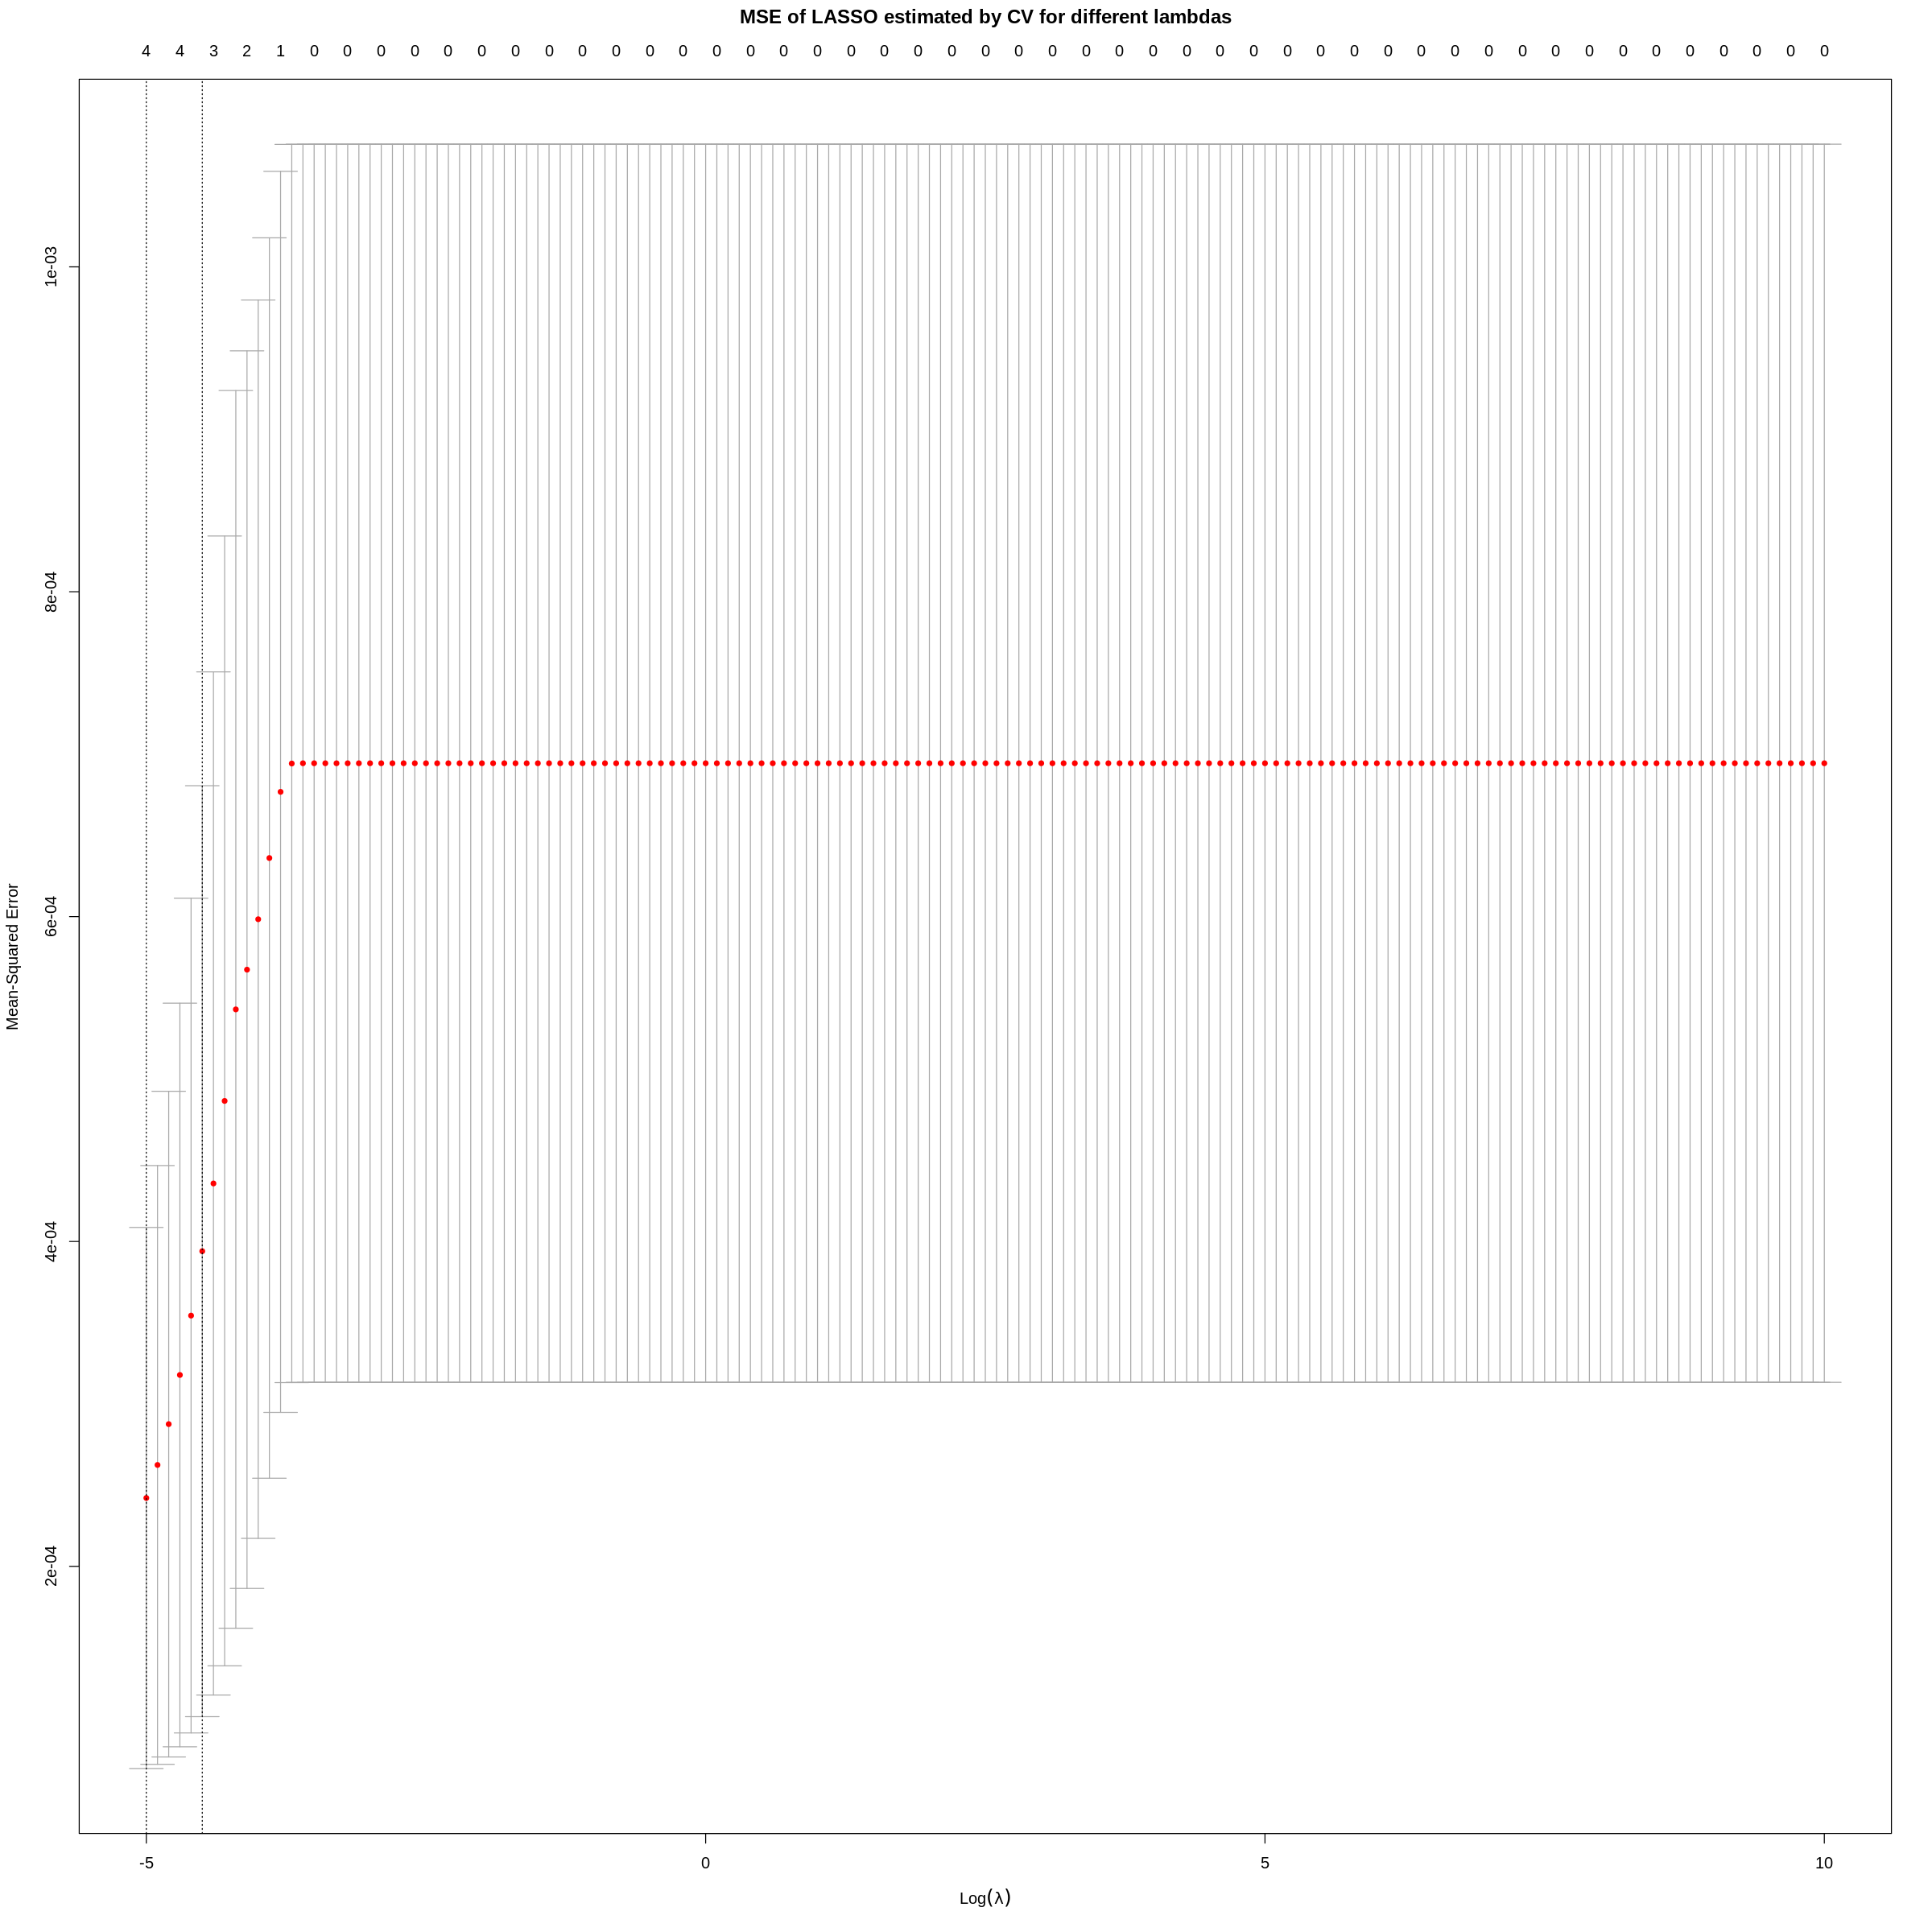

In [97]:
#lambda hyperparameter opmtimization with lasso
supplier_index_wide_train%>% select(one_day_oc_INTC)
cv_lambda_lasso <- cv.glmnet(
    x = x_train, 
    y = Y_train,
    alpha = 1,
    lambda = exp(seq(-5, 10, 0.1))
)
plot_data <- cv_lambda_lasso
plot(plot_data, main = "MSE of LASSO estimated by CV for different lambdas\n\n")

lasso_model <- glmnet(
    x = x_train, 
    y = Y_train,
    alpha = 1,
    lambda = cv_lambda_lasso$lambda.min
)

In [99]:
#listing covariates found by lasso
lasso_selected_covariates = lasso_model %>% coef() |>
                                as.matrix() |>
                                as_tibble(rownames='covariate') |>
                                filter(covariate != '(Intercept)' & abs(s0) > 10e-6) %>% 
                                pull(covariate)
lasso_selected_covariates

[1] "one_day_oc_LRCX" "one_day_oc_NATI" "one_day_oc_PAYC" "one_day_oc_PTC"

In [108]:
#building linear model
lin_model <- lm(one_day_oc_INTC ~ ., 
                data = supplier_index_wide_train[,c(lasso_selected_covariates, 'one_day_oc_INTC')])
lin_model


Call:
lm(formula = one_day_oc_INTC ~ ., data = supplier_index_wide_train[, 
    c(lasso_selected_covariates, "one_day_oc_INTC")])

Coefficients:
    (Intercept)  one_day_oc_LRCX  one_day_oc_NATI  one_day_oc_PAYC  
         0.1450           0.2385           0.2315           0.1904  
 one_day_oc_PTC  
         0.1941  


In [ ]:
#assessing accuracy
model_performance = supplier_index_wide_test |> 
    select(one_day_oc_INTC) |>
    cbind(predict(lin_model,
                  interval="prediction",
                  supplier_index_wide_test,
                  se.fit=TRUE)$fit
          ) |>
    rename(true_val = one_day_oc_INTC) |> 
    group_by(true_val) |>
    mutate(is_trueVal_in_PI = between(fit, lwr, upr)) |>
    ungroup()

model_performance

### References

Project Justification:
>Kenton, W. (2021, November 3). *Why stochastic modeling is less complicated than it sounds.* Investopedia. Retrieved November 7, 2021, from https://www.investopedia.com/terms/s/stochastic-modeling.asp. 

>Segal, E. (2021, July 12). *Worsening computer chip crisis shows supply chains are still at risk.* Forbes. Retrieved November 6, 2021, from https://www.forbes.com/sites/edwardsegal/2021/07/12/worsening-computer-chip-crisis-shows-supply-chains-are-still-at-risk/?sh=5d5386e5e3da. 

>Team, T. I. (2021, October 5). *How does the law of Supply and demand affect the stock market?* Investopedia. Retrieved November 7, 2021, from https://www.investopedia.com/ask/answers/040215/how-does-law-supply-and-demand-affect-stock-market.asp. 

>Wheatley, M. (2021, October 25). *Supply problems take a bite out of Intel's PC chip business and its stock falls hard.* SiliconANGLE. Retrieved November 7, 2021, from https://siliconangle.com/2021/10/21/supply-problems-take-bite-intels-pc-chip-business-stock-falls-hard/. 

Data Sources:
>Yahoo! (n.d.). *Yahoo Finance - Stock Market Live, quotes, Business & Finance News.* Yahoo! Finance. Retrieved November 6, 2021, from https://finance.yahoo.com/. 

>*List of INTC's suppliers and stock performance.* CSIMarket. (n.d.). Retrieved November 7, 2021, from https://csimarket.com/stocks/competitionNO2.php?supply&amp;code=INTC. 

